# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 6. Основы обработки текстов


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 100 баллов
* Задача 2 &mdash; 50 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [ ]:
# Bot check

# HW_ID: fpmi_ad6
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from string import punctuation
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torchtext
from torchtext.data.utils import get_tokenizer

import seaborn as sns

sns.set(palette="Set2")
sns.set_style("whitegrid")

import nltk

nltk.download("stopwords")

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture6.pdf" target="_blank">презентацию</a>, [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html) по RNN и [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem_llama.html) по генерации текста.

---
### Задача 1. Предсказание заработной платы


В этой задаче вам предлагается решить задачу регрессии &mdash; по текстовому описанию вакансии определить заработную плату. Для решения такой задачи можно применять различные методы, в том числе и те, которые были рассмотрены на лекции.
Мы будем решать эту задачу с помощью рекуррентной нейронной сети.

Датасет `salary_dataset.csv` лежит по <a target="_blank" href="https://drive.google.com/file/d/1Q3lCw_8Uad_OzHCjvLeYRvamXR74UPbW/view?usp=sharing">ссылке</a> (312.3 MB).

Если вы работаете локально:

> Просто скачайте этот файл и укажите пути к ним ниже.


Если вы используете <a target="_blank" href="https://colab.research.google.com/">Colab</a>:
> **Скачивать файл не обязательно**. Просто подключитесь к Google Drive:
>
> ```
> from google.colab import drive
> drive.mount('/content/drive/')
> ```
>
> Перейдите по ссылке файла и добавьте shortcut на него в ваш собственный диск:
> 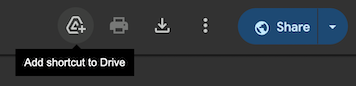

In [ ]:
from google.colab import drive
drive.mount('/drive')

# пути к нужным папкам в Drive
path = "/drive/MyDrive/ad"


!mkdir data/content
!cp -a /$path/. data/content/

Mounted at /drive
mkdir: cannot create directory ‘data/content’: No such file or directory
cp: cannot create directory 'data/content/': No such file or directory


Скачаем данные для обучения и тестирования:

In [ ]:
dataset = pd.read_csv('/drive/MyDrive/salary_dataset.csv')
dataset.head()

,FullDescription,SalaryNormalized
0,This is an exciting opportunity for a Recruite...,55000
1,Our client is looking for a .net web developer...,27500
2,"MS SQL Database Administrator Helsinki, Finla...",72098
3,ACADEMIC APPOINTMENTS A large secondary school...,32400
4,Head of User Experience c. ****k / London A H...,67500


Каждая строка содержит полное описание вакансии и соответствующую зарплату. При этом описания могут быть довольно длинными, например:

In [ ]:
dataset.iloc[0]["FullDescription"]

'This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. You will be responsible for developing and executing recruiting plans across the company. Your key accountabilities will include creating job descriptions, working closely with hiring managers, reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe. This job was originally posted as www.totaljobs.com/JobSeeking/RecruitmentManager_job****'

Для данной задачи нам не будут нужны служебные части речи и знаки пунктуации. Зададим токенизатор, списки стоп-слов и пунктуации.

In [ ]:
# Зададим токенизаторы
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
stop_words = nltk.corpus.stopwords.words("english")  # стоп-слова
punc = list(punctuation)  # пунктуация

Подготовьте словарь, оставив в нем только наиболее часто встречающиеся токены. Не забудьте предварительно убрать из предложений знаки пунктуации и стоп-слова.

*Можно использовать код с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).*

In [ ]:
# зададим счетчики
counter = Counter()

# посчитаем количество вхождений каждого токена
for text in dataset["FullDescription"]:
    counter.update(
        token
        for token in tokenizer(text)
        if token not in stop_words and token not in punc
    )

ordered_dict = OrderedDict(counter)
MAX_VOCAB_SIZE = 25000  # ограничение на словарь
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))

Этот упорядоченный словарь хранит слово и его встречаемость. Можно посмотреть на самые частые слова в датасете:

In [ ]:
list(ordered_dict.items())[:10]

[(' ', 666725),
 ('experience', 269289),
 ('The', 258645),
 ('role', 211475),
 ('work', 207318),
 ('team', 194087),
 ('This', 180149),
 ('within', 175173),
 ('You', 173743),
 ('skills', 162215)]

Теперь изменим словарь, добавив в него специальные токены, которые необходимы для подготовки данных к обучению:

In [ ]:
# зададим словарь
vocab = torchtext.vocab.vocab(ordered_dict)

unk_token = "<unk>"
pad_token = "<pad>"


def add_special_tokens(vocab):
    """Функция для добавления специальных токенов в словарь."""
    for special_token in [unk_token, pad_token]:
        vocab.append_token(special_token)
    vocab.set_default_index(vocab[unk_token])
    UNK_IDX = vocab[unk_token]
    PAD_IDX = vocab[pad_token]
    return vocab, UNK_IDX, PAD_IDX


vocab, UNK_IDX_EN, PAD_IDX_EN = add_special_tokens(vocab)
num_tokens = len(vocab)

Подготовим класс датасета:

In [ ]:
class SalaryPredictionDataset(Dataset):
    """Класс датасета для предсказания зарплаты"""

    def __init__(self, texts, target):
        """
        Параметры.
        1) texts (list) — корпус токенизированных текстов, на котором будет
                          происходить обучение
        2) labels (list) — истинные метки текстов
        """
        self.texts = texts
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.texts[idx], self.target[idx]

Допишите функцию для дополнения текста до максимальной длины в батче. Снова воспользуйтесь кодом с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

*Обратите внимание, что теперь вместо целочисленных меток мы используем вещественные таргеты. Если не поменять код с семинара, то вы можете решать неправильную задачу.*

In [ ]:
def pad_collate(batch):
    """
    Формирует тензоры из токенизированных текстов и таргетов, а также
    дополняет последовательности токенов до макс. длины в батче с UNK_IDX

    Вход:
    * batch — батч с текстами и таргетами

    Возвращает:
    * texts_tensors - список тензоров текстов из батча, дополненных паддингом
    * target - список соответствующих меток батча
    """
    texts, target = zip(*batch)

    # сформируем тензоры
    texts_tensors = [torch.LongTensor(t) for t in texts]
    target = torch.FloatTensor(target)

    texts_tensors = pad_sequence(
        texts_tensors, padding_value=PAD_IDX_EN, batch_first=True
    )

    return texts_tensors, target

Токенизируем текст, а таргет переведем во `float`.

In [ ]:
tokens = [vocab(tokenizer(text)) for text in dataset["FullDescription"]]
target = [float(value) for value in dataset["SalaryNormalized"]]

Каждому из текстов в датасете сопоставляется последовательность токенов, причем везде разного размера:

In [ ]:
for i in range(3):
    print(f"Количество токенов в {i}-м тексте - {len(tokens[i])}:\n  ", end="")
    for token in tokens[i][:10]:
        print(token, end=", ")
    print("...\nТаргет:", target[i], "\n")

Количество токенов в 0-м тексте - 122:
  6, 25000, 25000, 141, 18, 25000, 25000, 3605, 25000, 35, ...
Таргет: 55000.0 

Количество токенов в 1-м тексте - 73:
  67, 12, 25000, 14, 25000, 25000, 4674, 393, 871, 25000, ...
Таргет: 27500.0 

Количество токенов в 2-м тексте - 309:
  573, 186, 1517, 658, 0, 24450, 25000, 15730, 13311, 87, ...
Таргет: 72098.0 



При решении задач регрессии с помощью нейросетей удобнее всего бывает перевести предсказываемые значения в небольшой диапазон, например, от 0 до 1. Это нужно, чтобы повысить численную стабильность обучения &mdash; не нагружать модель большими значениями таргетов. В нашей задаче это важно, ведь зарплата может иметь большой разброс и принимать большие значения.

Чтобы сделать это, воспользуемся преобразованием `MinMaxScaler` из библиотеки `sklearn`, которое мы рассматривали в [задаче 3 задания 3](https://miptstats.github.io/courses/ad_fivt/task3.html#%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0-3.).
Таким образом, мы получим значения, удобные для использования при обучении.

In [ ]:
train_tokens, valid_tokens, train_target, valid_target = train_test_split(
    tokens, target
)

scaler = MinMaxScaler()
train_target_std = scaler.fit_transform(np.array(train_target).reshape(-1, 1))
valid_target_std = scaler.transform(np.array(valid_target).reshape(-1, 1))

train_data = SalaryPredictionDataset(train_tokens, train_target_std)
valid_data = SalaryPredictionDataset(valid_tokens, valid_target_std)
len(train_data), len(valid_data)

(150000, 50000)

Посмотрим на отмасштабированные значения зарплаты:

In [ ]:
print("Преобразованные таргеты:")
for t in train_data[:3][1]:
    print(round(t.item(), 4), end=", ")
print("...")

Преобразованные таргеты:
0.2564, 0.1308, 0.1128, ...


Сформируйте даталоадеры для обучения и валидации.

In [ ]:
BATCH_SIZE = 64  # размер батча

# сформируем даталоадеры
train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate
)

valid_loader = DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate
)

Наконец, можем подготовить модель. Будем использовать рекуррентную архитектуру, подобную той, что была на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.ipynb).
Отличие состоит в том, что теперь мы предсказываем не метку класса, а вещественный таргет. Подумайте, какую часть сети нужно изменить, чтобы адаптировать ее к нашей задаче.

In [ ]:
class SimpleRNNRegressor(nn.Module):
    """ Модель для регрессии на основе LSTM"""

    def __init__(
        self,
        num_tokens,
        emb_size=512,
        rnn_num_units=64,
        output_dim=1,
        layers=1
    ):
        """
        1) num_tokens — общее количество токенов,
        2) emb_size — размер эмбеддингового пространства,
        3) rnn_num_units - размер пространства скрытых представлений в rnn,
        4) output_dim - размерность выхода-предсказания.
        """
        super(self.__class__, self).__init__()

        self.emb = nn.Embedding(num_tokens, emb_size, padding_idx=PAD_IDX_EN)
        self.rnn = nn.LSTM(input_size=emb_size, hidden_size=rnn_num_units, batch_first=True, num_layers=layers)
        self.classifier = nn.Linear(rnn_num_units, output_dim)

    def forward(self, x):
        """
        * x — общее количество токенов.

        Возвращает:
        * predictions - предсказания модели.
        """
        # x.shape = (batch_size, max_pad_len)

        # Получим эмбеддинги для входов
        # (batch_size, max_pad_len, emb_size)
        emb = self.emb(x)

        # Прогоним через RNN-сеть и получим скрытое состояние,
        # в котором хранится нужная информация о последовательности
        # (batch_size, rnn_num_units)
        _, (h_state, _) = self.rnn(emb)

        # Прогоним через полносвязный слой и получим логиты для каждого токена
        # (batch_size, num_tokens)
        predictions = self.classifier(h_state.squeeze(0))
        return predictions

Так как теперь решаем задачу регрессии, вместо точности модели будем измерять среднеквадратичную ошибку:

In [ ]:
def mse(preds, y):
    """
    Возвращает среднеквадратичную ошибку модели.

    Параметры.
    1) preds — предсказания модели,
    2) y — истинные значения таргета.
    """

    return F.mse_loss(preds, y, reduction="mean")

Допишите функции для обучения и валидации. Они почти не будут отличаться от тех, что были на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

In [ ]:
def train(model, iterator, optimizer, criterion, train_loss_history):
    """
    Функция для обучения модели на обучающем датасете и подсчёта
    её ошибки.

    Параметры.
    1) model — модель,
    2) iterator — итератор обучающего датасета,
    3) optimizer — класс метода оптимизации,
    4) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0
    model.train()

    # Проход по всему датасету
    for batch_id, batch in enumerate(iterator):
        #  чтобы градиент не накапливался, его нужно обнулить
        optimizer.zero_grad()
        # получим предсказания модели
        texts, labels = batch
        texts, labels = texts.to(device), labels.to(device)
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels)
        mse_ = mse(predictions, labels)

        # сделаем back-propagation для подсчёта градиентов
        loss.backward()
        # выполним шаг оптимизатора
        optimizer.step()
        # обновим метрики
        epoch_loss += loss.item()
        epoch_mse += mse_.item()
        train_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def evaluate(model, iterator, criterion, val_loss_history=None):
    """
    Функция для применения модели на валидационном/тестовом датасете и подсчёта
    её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор датасета,
    3) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0

    model.eval()

    with torch.no_grad(): # отключим подсчёт градиентов на валидации
        for batch_id, batch in enumerate(iterator):
            texts, labels = batch
            texts, labels = texts.to(device), labels.to(device)
            # получим предсказания
            predictions = model(texts).squeeze(1)
            # посчитаем метрики
            loss = criterion(predictions, labels)
            mse_ = mse(predictions, labels)
            # обновим метрики
            epoch_loss += loss.item()
            epoch_mse += mse_.item()
            if val_loss_history is not None:
                val_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def epoch_time(start_time, end_time):
    """
    Функция для подсчёта времени работы одной эпохи.

    Параметры.
    1) start_time — время начала запуска,
    2) end_time — время завершения работы эпохи.
    """

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Теперь определим итоговую функцию для всего цикла обучения:

In [ ]:
def visualize_epoch(epoch, start_time, loss_history, mse_history):
    """
    Функция для визуализации 1 эпохи.

    Параметры.
    1) epoch — номер эпохи,
    2) start_time — время начала эпохи,
    3) loss_history - tuple истории лосса на train и test,
    4) mse_history - tuple истории MSE на train и test.
    """
    # Посчитаем время работы одной эпохи
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Отобразим графики лоссов
    clear_output(True)
    plt.figure(figsize=(18, 6))

    train_loss_history, val_loss_history = loss_history
    plt.subplot(1, 3, 1)
    plt.plot(train_loss_history)
    plt.title("Train Loss")
    plt.xlabel("Номер батча")
    plt.subplot(1, 3, 2)
    plt.plot(val_loss_history, color="tab:orange")
    plt.title("Valid Loss")
    plt.xlabel("Номер батча")

    # Отрисуем значение MSE от эпохи
    train_mse_history, val_mse_history = mse_history
    plt.subplot(1, 3, 3)
    plt.plot(train_mse_history, label="Train")
    plt.plot(val_mse_history, label="Valid")
    plt.legend()
    plt.title("MSE")
    plt.xlabel("Номер эпохи")
    plt.show()

    print(
        f"Номер эпохи: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s"
    )


def training_loop(model_instance, n_epochs=10):
    """
    Функция для обучения нейронной сети.

    Параметры.
    1) model_instance — обучаемая модель,
    2) n_epochs — количество эпох.
    """

    best_valid_loss = float("inf")
    train_loss_history = []
    val_loss_history = []
    train_mse_history = []
    val_mse_history = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Обучим одну эпоху на обучающем датасете
        train_loss, train_mse = train(
            model_instance,
            train_loader,
            optimizer,
            criterion,
            train_loss_history,
        )
        train_mse_history.append(train_mse)

        # Оценим ошибку модели на тестовом датасете
        valid_loss, valid_mse = evaluate(
            model_instance, valid_loader, criterion, val_loss_history
        )
        val_mse_history.append(valid_mse)

        # Если значение функции потерь улучшилось, сохраним параметры модели
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), "model_checkpoint.pt")

        # Визуализируем результаты эпохи
        visualize_epoch(
            epoch,
            start_time,
            (train_loss_history, val_loss_history),
            (train_mse_history, val_mse_history),
        )

In [ ]:
# У нас задача регрессии, будем использовать MSELoss
criterion = nn.MSELoss()

history = []

# Задайте параметры сети
model = SimpleRNNRegressor(
    num_tokens=len(vocab),
    emb_size=256,
    rnn_num_units=8,
    output_dim=1,
    layers=10,
    ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
# Посмотрите на получившуюся модель
model

SimpleRNNRegressor(
  (emb): Embedding(25002, 256, padding_idx=25001)
  (rnn): LSTM(256, 8, num_layers=10, batch_first=True)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

Обучите несколько моделей с различными гиперпараметрами (например, шаг обучения, размер словаря, архитектура) и сравните их качество на тестовой выборке.

*Не пугайтесь, если у вас не будет получаться хорошее качество на валидации: решаемая задача довольно сложная, а RNN &mdash; достаточно простая архитектура. Но постарайтесь, чтобы модель хотя бы не вырождалась в константу. Для этого следите за переобучением!*

*На 3 курсе вы сможете познакомиться с моделями, которые решают такую задачу гораздо лучше.*

###Модель 1###

In [ ]:
model = SimpleRNNRegressor(
    num_tokens=len(vocab),
    emb_size=256,
    rnn_num_units=6,
    output_dim=1,
    layers=2,
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
history = []

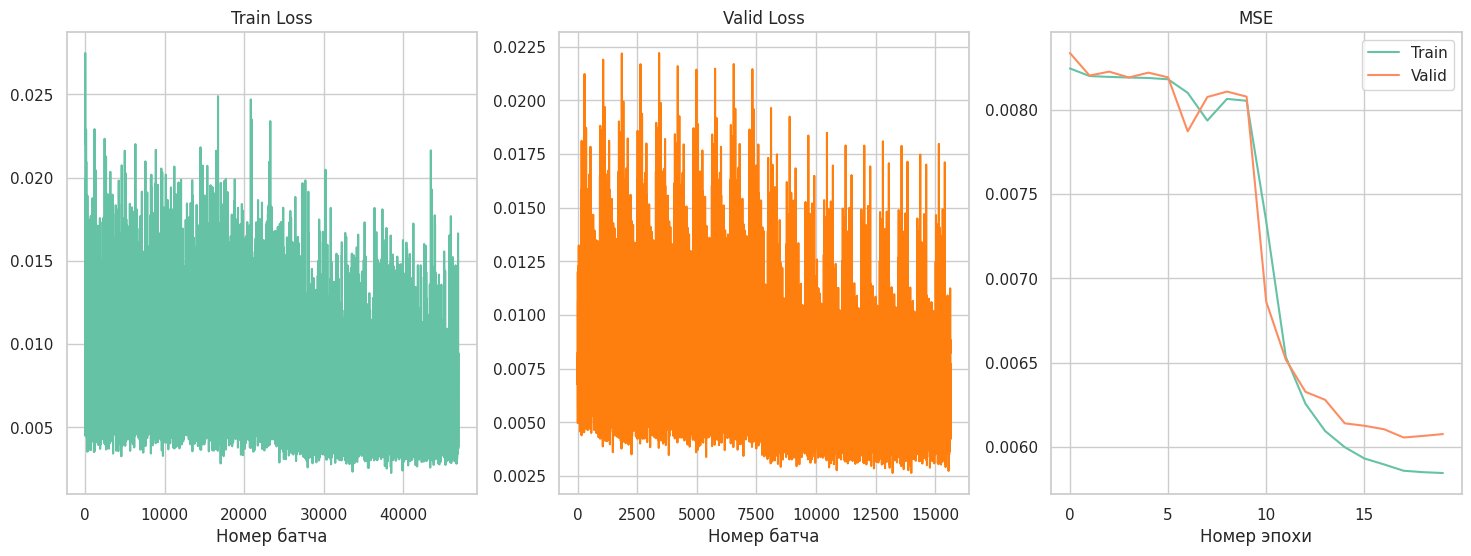

Номер эпохи: 20 | Время обучения эпохи: 0m 32s


In [ ]:
training_loop(model.to(device), n_epochs=20)

Модель начинает заметно обучаться после 9 эпохи

Модель 2

In [ ]:
model = SimpleRNNRegressor(
    num_tokens=len(vocab),
    emb_size=256,
    rnn_num_units=16,
    output_dim=1,
    layers=1,
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
history = []

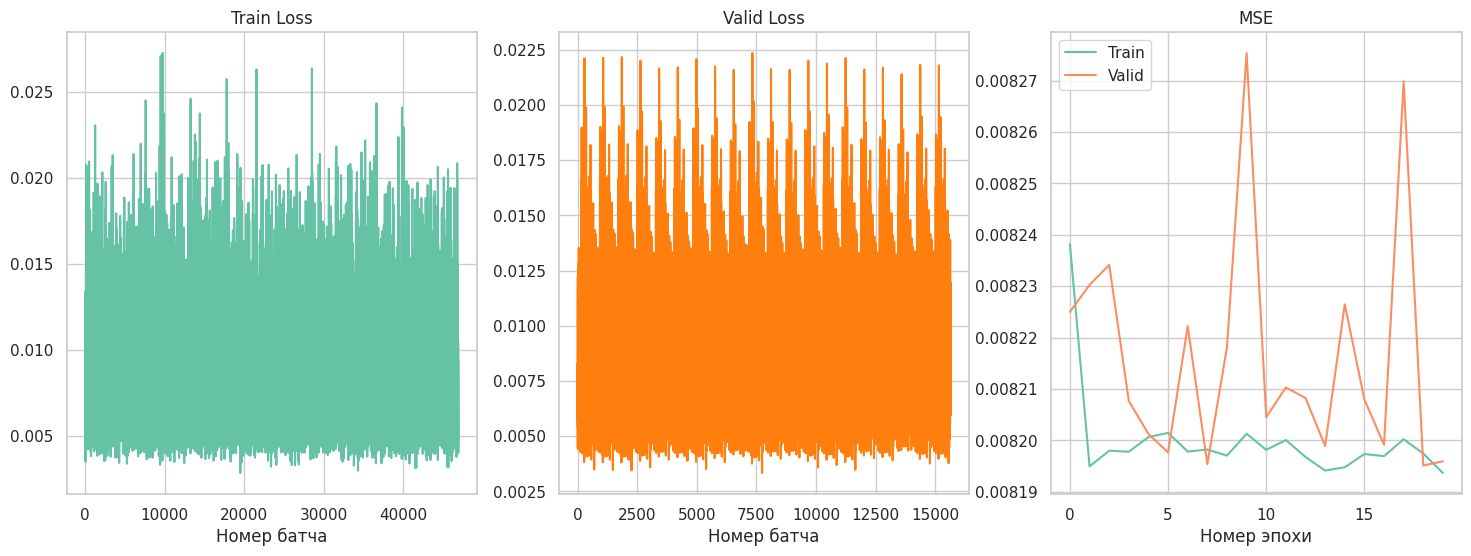

Номер эпохи: 20 | Время обучения эпохи: 0m 36s


In [ ]:
training_loop(model, n_epochs=20)

Модель практически не обучается

Модель 3

In [ ]:
model = SimpleRNNRegressor(
    num_tokens=len(vocab),
    emb_size=256,
    rnn_num_units=16,
    output_dim=1,
    layers=5,
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
history = []

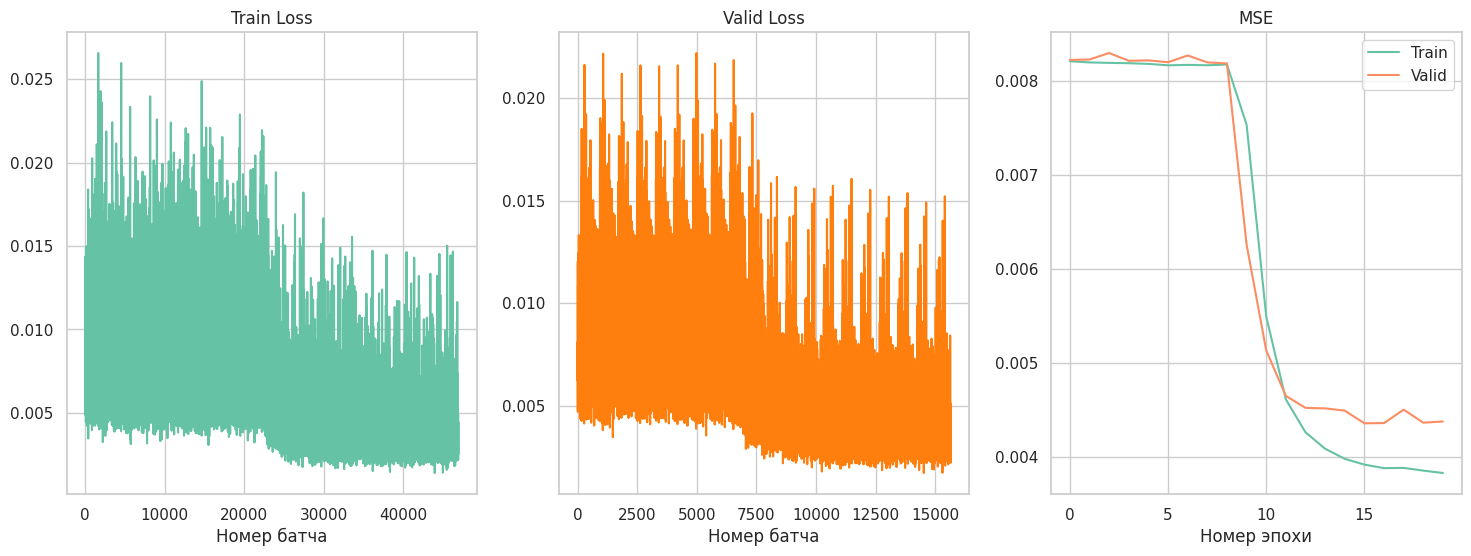

Номер эпохи: 20 | Время обучения эпохи: 0m 49s


In [ ]:
training_loop(model, n_epochs=20)

Модель дает самый лучший результат среди сех остальных, начинает обучаться после 8 эпохи и давольно резко

Модель 4

In [ ]:
model = SimpleRNNRegressor(
    num_tokens=len(vocab),
    emb_size=256,
    rnn_num_units=8,
    output_dim=1,
    layers=5,
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
history = []

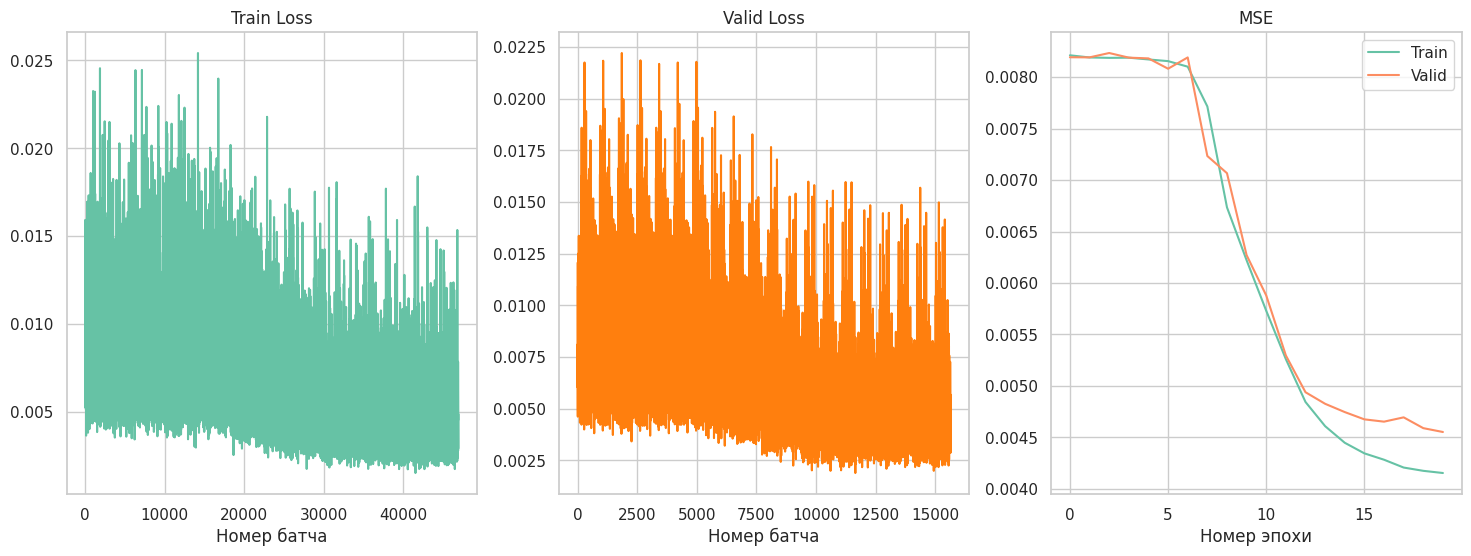

Номер эпохи: 20 | Время обучения эпохи: 0m 44s


In [ ]:
training_loop(model, n_epochs=20)

Модель ведет себя примерно как и треться, но начинает обучаться раньше и не так хорошо

Модель 5

In [ ]:
model = SimpleRNNRegressor(
    num_tokens=len(vocab),
    emb_size=256,
    rnn_num_units=5,
    output_dim=1,
    layers=10,
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
history = []

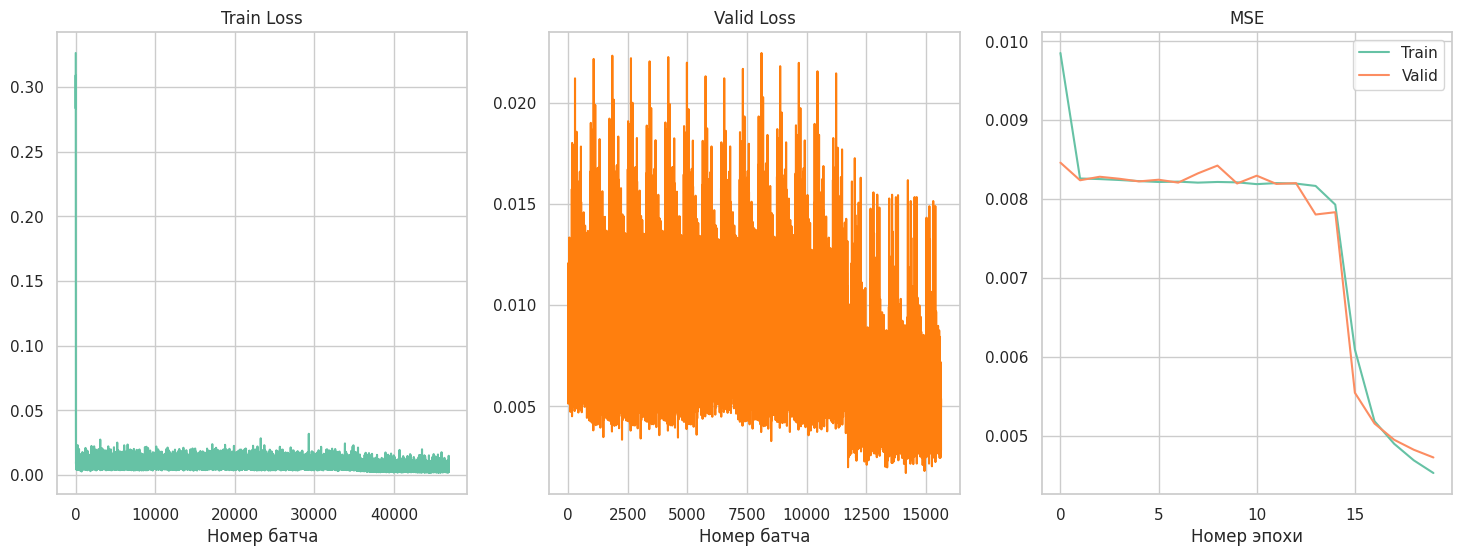

Номер эпохи: 20 | Время обучения эпохи: 1m 7s


In [ ]:
training_loop(model, n_epochs=20)

Модель начинает обучаться после 13 эпохи и не достигает уровня двух предыдущих

Выведите несколько примеров работы на тестовой выборке: текст вакансии, предсказание вашей модели и истинное значение зарплаты. Чтобы вернуть все значения к изначальным масштабам, используйте `scaler.inverse_transform(...)`. Также посчитайте MSE на всей тестовой выборке.

Будем проверять на самой лучшей, тоесть третьей моделе. MSE у нее 0.0043

In [ ]:
indices = torch.randint(low=0, high=len(dataset), size=(5,))
with torch.no_grad():
    for idx in indices:
        text, target = dataset.loc[int(idx)]
        tokens = vocab(tokenizer(text))
        tokens = torch.LongTensor(tokens).to(device)
        output = model(tokens).squeeze(1)
        print('=' * 20 + '\n')
        print(f'Тext: {text[:250]}...')
        print(f'Истинное значение: {target}')
        print(f'Предсказание: {int(scaler.inverse_transform(output.cpu()[-1].reshape(1, -1)).item())}')


Тext: Technical Product Manager  LAMP  Windows  Java  SQL  Software Development Life Cycle  Stakeholder Management  Fluent German. Technical Product Manager  Great opportunity for a Technical Product Manager to join a reputable organisation taking ownershi...
Истинное значение: 50000
Предсказание: 51064

Тext: Our Client one of the countries leading insurance agencies are looking for a Sales Executive to join their rapidly expanding team. Your role will be to provide quotations and to negotiate To provide insurance quotations to prospective clients in a po...
Истинное значение: 25000
Предсказание: 25814

Тext: Our client, a highly respected insurer based in Herts, is looking to recruit a Claims Manager to manage the Household claims division. You will have overall responsibility for up to **** staff and be responsible for the management of both people and ...
Истинное значение: 42500
Предсказание: 38490

Тext: My Client, one of the UK s most dynamic and fastgrowing Facilities Manageme

**Вывод:** С помощью RNN мы смогли предсказывать зарплату по описанию вокансии. Хоть RNN и вестьма примитивна, но предсказания иногда бывют довольно точными, что не может не радовать

Проанализировав различные модели можно сделать вывод, что наиболее выжно количество слоев у модели. Так модель с одним слоем так и не обучилась нормально, в то время как остальные начали обучаться. rnn_num_units тоже влияет на качество обучения. Так при прочих равных модель с большим rnn_num_units показывает лучшее качество. Так же стоит заметить, что чем больше эпох, тем лучше качество, возможно, если поставить 100 эпох, то можель будет очень хорошо справляться с данной задачей, но скорее всего просто переобучится

Стоит отметить, что время сильнее всего зависит от количества слоев, при увеличении числа слоев время обучения растет довольно сильно.

---
### Задача 2. Использование большой языковой модели


Ваша задача &mdash; применить <a target="_blank" href="https://llama-2.ai/">Llama 2</a> к предыдущей задаче и заставить ее предсказать заработную плату по текстовому описанию. Существует мало русскоязычных моделей, способных решить такую задачу и помещающихся в <a target="_blank" href="https://colab.research.google.com/">Colab</a>, поэтому вам придется писать запросы на английском!

In [3]:
!pip install bitsandbytes==0.41.1 transformers==4.34.1 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 auto-gptq==0.4.2  > null
import transformers
import bitsandbytes as bnb

assert torch.cuda.is_available(), "для этой части понадобится GPU"

In [ ]:
print(dataset.iloc[100]["FullDescription"], dataset.iloc[100]["SalaryNormalized"])
print(dataset.iloc[300]["FullDescription"], dataset.iloc[300]["SalaryNormalized"])
print(dataset.iloc[301]["FullDescription"], dataset.iloc[301]["SalaryNormalized"])
print(dataset.iloc[44]["FullDescription"], dataset.iloc[44]["SalaryNormalized"])

Position: Junior Packaging Designer Location: London Salary: ****k Ref: **** Client based in West London is currently on the look out for junior packaging designer to join the studio team. The company specialise in a wide range of packaging for a number of products The ideal candidate will have some commercial experience may be a placement or some freelance work. Good set of packages to a high standard As well as the finished work would be good to show some sketch work in the examples. If you can **** or **** examples on a PDF document something to present to the client. Please make sure that your full address and details are included in your application for this role 13000
Job Title  PLC Software Engineer Location  Birmingham or Bedford Up to **** per annum (experience dependant)  Car The Role Our client is a rapidly expanding multimillion pound business with sites across Europe. Specialising in fully automated materials handling solutions their customers include the likes of BMW, Ben

Дисклеймер: *использовать LLM в рамках ограничений Colab хоть и возможно, но очень трудно.*

> Так как процесс генерации очень хрупкий и может сломаться при любом неверном движении, мы настоятельно рекомендуем **сохранить результаты предыдущего задания в отдельном файле** и приступать к этой задаче в самом конце. Решения задач можно сдавать в бот разными файлами.

> Если у вас возникла ошибка `Out of memory`, перезапустите ноутбук и попробуйте снова. Да, языковые модели без своей GPU &mdash; это тяжело...





От вас требуется подобрать такой промпт, который приводил бы к нужному выводу модели. Можете экспериментировать с параметрами генерации, список которых можно посмотреть в <a target="_blank" href="https://github.com/huggingface/transformers/blob/c4d4e8bdbd25d9463d41de6398940329c89b7fb6/src/transformers/generation_utils.py#L101">исходнике</a>.

Существуют различные техники, которые могут помочь вам "разговорить" языковую модель. О многих из них вы сможете прочитать <a target="_blank" href="https://docs.mistral.ai/guides/prompting-capabilities/">здесь</a>. В нашем случае полезным может быть метод Few-Shot Learning, который заключается в предоставлении модели нескольких примеров.

In [4]:
model_name = "TheBloke/Llama-2-13B-GPTQ"

# Загружаем Llama токенизатор
tokenizer = transformers.LlamaTokenizer.from_pretrained(
    model_name, device_map=device
)
tokenizer.pad_token_id = tokenizer.eos_token_id

# И саму модель Llama
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    offload_state_dict=True,
)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [8]:
prompt = '''Your task is to predict the employee’s salary based on the job description.

            ###
            Some examples for you:
            Description:
            Position: Junior Packaging Designer Location: London Salary: ****k Link: **** A client from West London is currently looking for a junior packaging designer to join the studio team. The company specializes in a wide range of packaging for a number of products, the ideal candidate should have some experience in the commercial field, perhaps as an intern or freelance employee. A good set of packages at a high level, as well as finished works, would be nice to show in examples. If you can **** or **** give examples in a PDF document to present something to the client. Please make sure that your full address and details are indicated in the application for this position
            Salary: 13,000


            Description:
            Position PLC Software Engineer, Location Birmingham or Bedford, Salary up to **** per year (depends on experience) Working in this position Our client is a fast-growing multimillion-dollar business with branches throughout Europe. Their clients specializing in fully automated material handling solutions include companies such as BMW, Bentley, Aston Martin, Amazon and Parcel Force, among many others. They are urgently looking for a PLC software engineer to join their experienced team. Candidates should be able to program a PLC from scratch, Siemens or Rockwell is preferable, but not necessarily. The successful candidate will work closely with both project managers and engineers, as well as sales staff and contractors on site, to ensure that the project is completed on time according to schedule. Most of your time will be spent writing code for fully automated systems, and the rest will be spent working with on-site installation engineers. The PLC software engineer will also have to troubleshoot and communicate with the service support staff to troubleshoot problems that may require a radical solution. The successful candidate will also have to work locally if necessary. The candidate who will successfully complete your application must have the following skills or qualities: Must be able to write PLC code from scratch (preferably Siemens S**** or Rockwell). Must be prepared to travel around the UK and stay away from it. Must be highly motivated. At least 5 years of experience writing code. Advantages: The base salary is up to **** depending on experience. There is a large selection of official cars available, including Audi and BMW. Holidays are 23 days **** statutory days. Pension provision and medical care under the Bupa program are available. Funded training is available
            Salary: 36,500


            Description:
            Specialist in MRI Radiology in Cambridge ******** Regional benefit I am currently recruiting an experienced specialist in MRI radiology to work at a private clinic in Cambridge. Your main responsibilities will include: providing highly qualified and specialized MRI imaging to patients in the radiology department. You will develop positive working relationships with consultant users and general practitioners and maintain effective working relationships in the hospital. For whom we are looking for people with higher education (bachelor's degree with honors in radiography or an equivalent qualification). Postgraduate qualifications in the field of MRI, as well as work experience in the UK in the field of imaging, including a period of specialization in the field of MRI. For more information or to apply for this position, please call Lydia Robinson at ******** and send your RESUME to: lydia.robinsonappointgroup.co.uk
            Salary: 30,500
            ###


            Description:
            Experience Wayside Communication Systems Engineer, required to work with a leading Train company in the East Midlands. Must have worked at Systems Architect level, covering Hardware, Software and Systems solutions. As an experienced train to wayside communications systems engineer, the primary activities involved in the role are to develop the communications and dataprocessing philosophies and technical roadmap, define the hardware architectures, liaise with suppliers, specify software requirements and vehicle test the resultant systems. You will also be required to commission the communications and dataprocessing systems on the trains and on the wayside postmanufacture, and to investigate and determine solutions for any problems found in use. In addition, you will need to provide cost and schedule estimates on complicated engineering programs, and provide technical expertise in support of other departments and less experienced engineering personnel. Qualifications Functional Knowledge: Degree and/or Chartered status essential (or similar), Masters Degree desirable. Technical domain experience essential, System Integration experience essential, System Architectural understanding essential. Rail experience preferred. Significant experience and hands on delivery of the design, analysis, development, testing and delivery of engineering solutions that solve complex requirements. Provide cost and schedule estimates on complicated engineering programs. Provide technical expertise in train to wayside communication systems Be able to demonstrate the ability to use this technical knowledge in the support of other departments (engineering, production, procurement, projects) and the development of less experienced engineering personnel. To apply for this position, candidates must be eligible to live and work in the UK Matchtech is acting as an Employment Business in relation to this vacancy.
            What is the salary for this job? (answer only with a number)'''
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)

output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=True, temperature=0.8)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))

print("Input batch (encoded):", batch)


Output: <s>Your task is to predict the employee’s salary based on the job description.

            ###
            Some examples for you:
            Description:
            Position: Junior Packaging Designer Location: London Salary: ****k Link: **** A client from West London is currently looking for a junior packaging designer to join the studio team. The company specializes in a wide range of packaging for a number of products, the ideal candidate should have some experience in the commercial field, perhaps as an intern or freelance employee. A good set of packages at a high level, as well as finished works, would be nice to show in examples. If you can **** or **** give examples in a PDF document to present something to the client. Please make sure that your full address and details are indicated in the application for this position
            Salary: 13,000


            Description:
            Position PLC Software Engineer, Location Birmingham or Bedford, Salary up to **** 

Если почувствуете, что у вас не получается добиться от модели желаемого, вы можете попробовать воспользоваться любой другой языковой моделью на ваш выбор, но тогда вы получите **не больше 30 баллов**.

В случае использования другой модели предоставьте скриншот ответа LLM и промпт, который вы использовали (в текстовом формате). Его можно вставить прямо в ноутбук или прислать в бот отдельным файлом.

**Вывод:** Вероятно проблема в промтах, но тем ни менее. Данная модель работает отвратительно и не понимает, что от нее хотят. Очень сложно добиться от нее вывода числа, а не какого то непонятного текста. Предсказанная зарплата довольно далека от реальной (примерно на 25%), но и на том спасибо. При одном и том же запросе могут быть совершенно разные ответы (как будто из разных вселенных). Для обучения мы использовали способ few-shot, чтобы дать модели несколько примеров

---
*Если хотите отточить навык написания промптов &mdash; **prompt-engineering** &mdash; можете попробовать сыграть в <a target="_blank" href="https://gandalf.lakera.ai/">игру</a>. В ней нужно заставить Гендальфа выдать пароль. Со временем уровни становятся все сложнее и требуют более хитрых приемов.*